In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import os
import statsmodels
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

mpl.rcParams['figure.figsize'] = (30, 10)
mpl.rcParams['axes.grid'] = False

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Professional Languages pre-processing

In [2]:
#attach google drive folder to read datasets
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv("/content/drive/My Drive/Project/GithubDataset/profesionalLanguages.csv")
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,events_repo_language,events_count_pull_request,created_at
0,JavaScript,432344,2019
1,Python,289138,2019
2,Java,192703,2019
3,TypeScript,180745,2019
4,Go,159997,2019


In [3]:
#create a copy of the original df and rename the columns
df1 = df
df1.columns = ['Language','Count','Year']
df1.head()

,Language,Count,Year
0,JavaScript,432344,2019
1,Python,289138,2019
2,Java,192703,2019
3,TypeScript,180745,2019
4,Go,159997,2019


In [4]:
print(df1['Language'].nunique()) # number of different languages in the dataset

312


In [5]:
#save each language df into a dictionary key
professional_languages_dict = {}

unique_languages = list(df1['Language'].unique())
for i in unique_languages:
  temporal_df = df1.loc[df1['Language']==i]
  professional_languages_dict[i] = temporal_df
  temporal_df = None

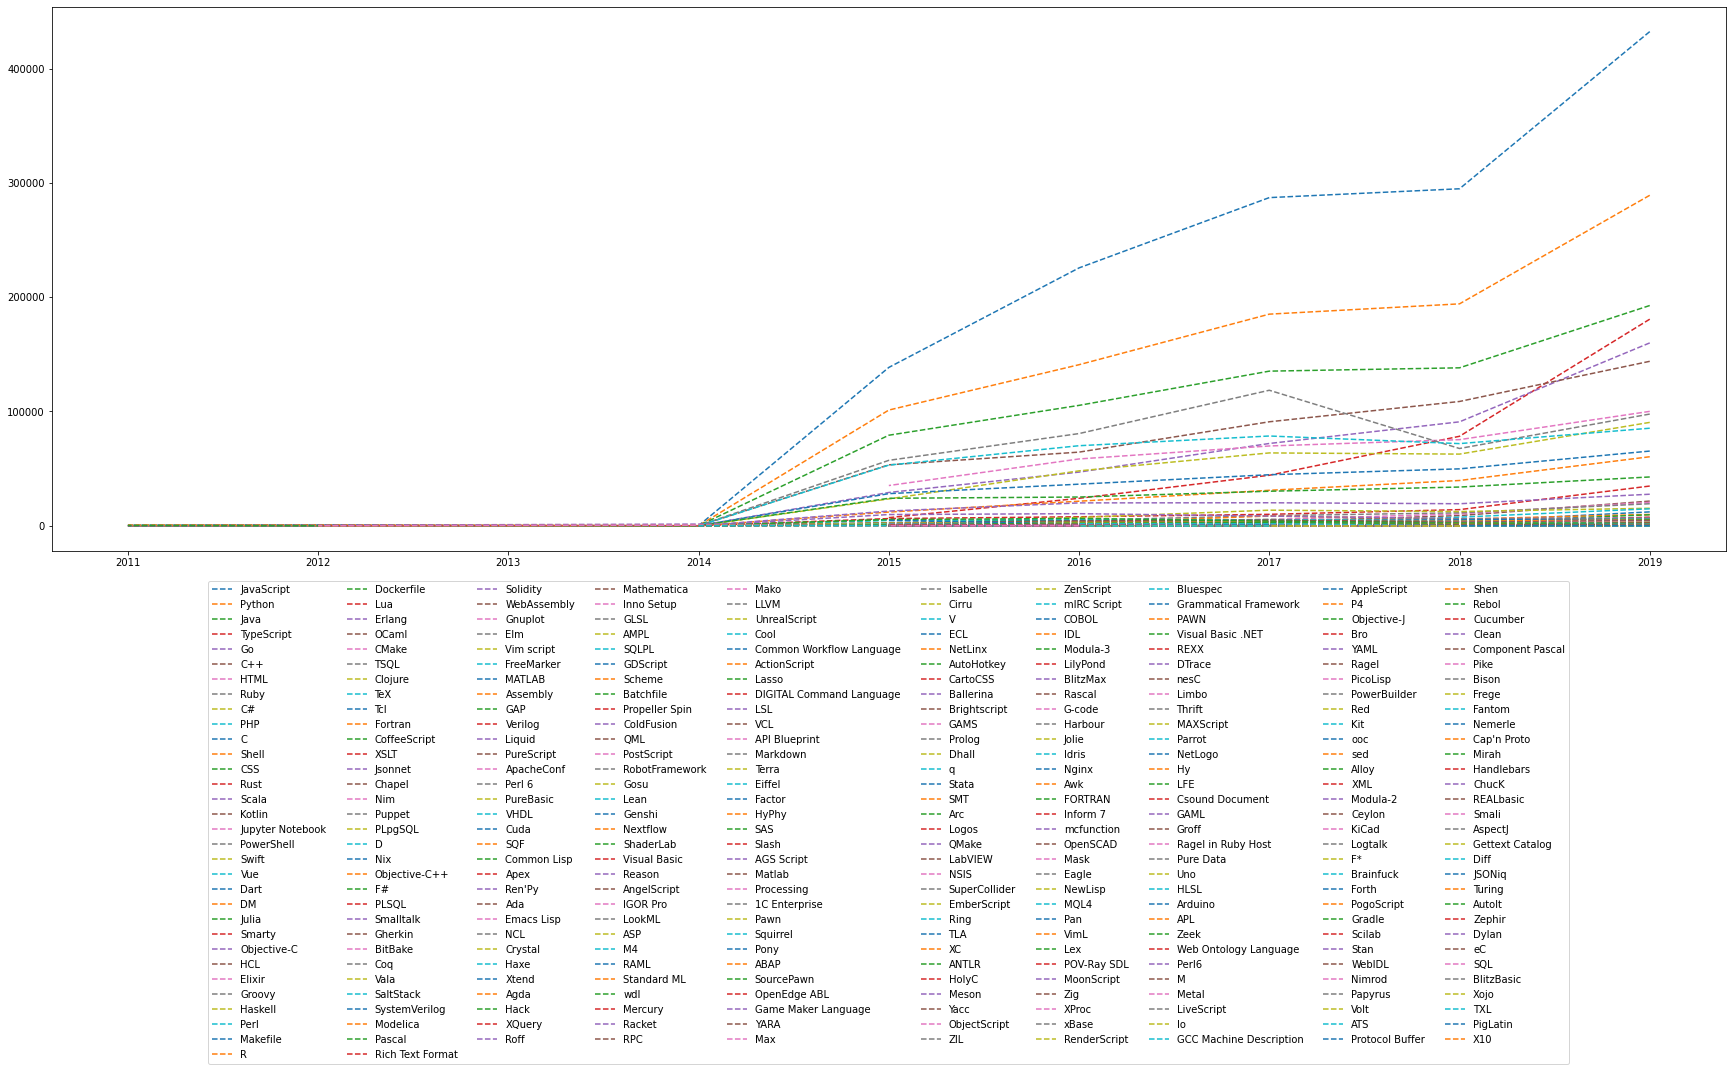

In [42]:
#plot each professional language trend
for key,value in professional_languages_dict.items():
  plt.plot(value['Year'], value['Count'], '--', label=str(key))

plt.legend(loc='center',ncol=10,bbox_to_anchor=(0.5, -0.5))
mpl.rcParams['figure.figsize'] = (30, 10)
mpl.rcParams['axes.grid'] = False
plt.show()

# All the languages pre-processing

In [7]:
#specify the years to read for the general purporses languages
years = (2011,2012,2013,2014,2015,2016,2017,2018,2019)

#create empty df
general_df = pd.DataFrame(columns=['events_repo_language','events_count_pull_request','created_at'])

#read each year csv and append it to the general df
for i in years:
  temp_df = pd.read_csv("/content/drive/My Drive/Project/GithubDataset/{}.csv".format(i))
  temp_df['created_at'] = pd.to_datetime(temp_df['created_at'], infer_datetime_format=True)
  # temp_df = pd.read_csv("/content/drive/My Drive/Project/GithubDataset/{}.csv".format(i),parse_dates=['created_at'])

  general_df = general_df.append(temp_df,ignore_index=True)
  temp_df = None

In [8]:
from datetime import  datetime

general_df.columns = ['Language','Count','Year']
general_df['Count'] = pd.to_numeric(general_df['Count'])
indexedDataset = general_df.set_index(['Year'])
indexedDataset.sort_index(inplace=True)
# print(general_df.head())
# print(general_df.tail())

# general_df.to_csv("generalLanguages.csv")

indexedDataset

,Language,Count
Year,,
2011-10-01,Ruby,4223
2011-10-01,HaXe,11
2011-10-01,Objective-J,11
2011-10-01,Matlab,11
2011-10-01,Factor,7
...,...,...
2019-12-01,Haxe,202
2019-12-01,Vala,208
2019-12-01,Scheme,210


In [9]:
#store each language df into a dictionary key
general_languagues_dict = {}

general_languages_list = list(indexedDataset['Language'].unique())
for i in general_languages_list:
  temp_df = indexedDataset.copy().loc[indexedDataset['Language'] == i]
  temp_df.drop(['Language'],axis=1,inplace=True)
  general_languagues_dict[i] = temp_df
  temp_df = None

In [10]:
general_languagues_dict['Python'].index
general_languagues_dict['Python']

,Count
Year,
2011-10-01,3173
2011-12-01,3539
2012-01-01,4508
2012-02-01,4970
2012-03-01,6756
...,...
2019-08-01,168980
2019-09-01,166552
2019-10-01,330730


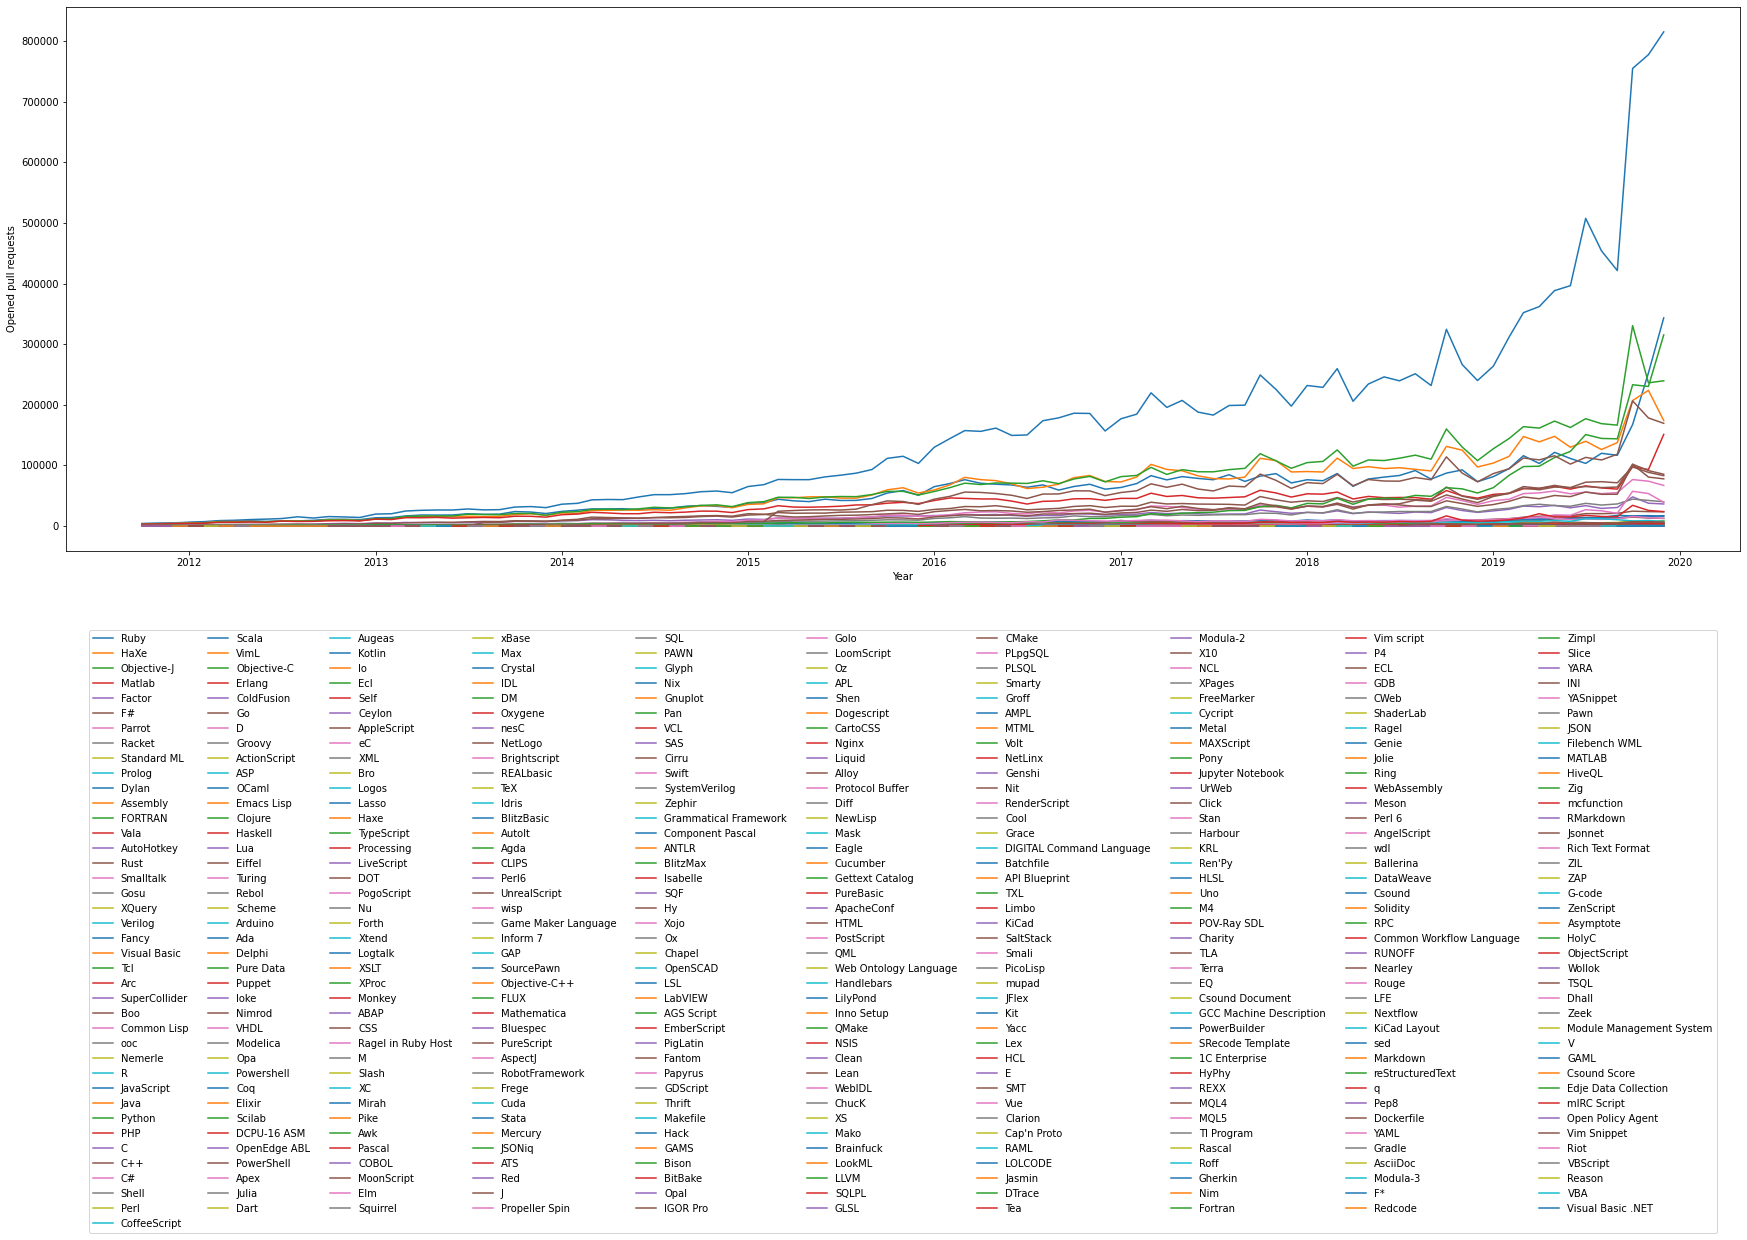

In [11]:
for key in general_languagues_dict.keys():
  plt.xlabel("Year")
  plt.ylabel("Opened pull requests")
  plt.plot(general_languagues_dict[key],'-',label=str(key))
    

plt.legend(loc='center',ncol=10,bbox_to_anchor=(0.5, -0.7))
mpl.rcParams['figure.figsize'] = (30, 10)
mpl.rcParams['axes.grid'] = False
plt.show()

# for key,value in general_languagues_dict.items():
#   plt.xlabel("Year")
#   plt.ylabel("Opened pull requests")
#   plt.plot(general_languagues_dict[key])


# plt.plot(value['Year'],value['Count'],'-',label=str(key))
    

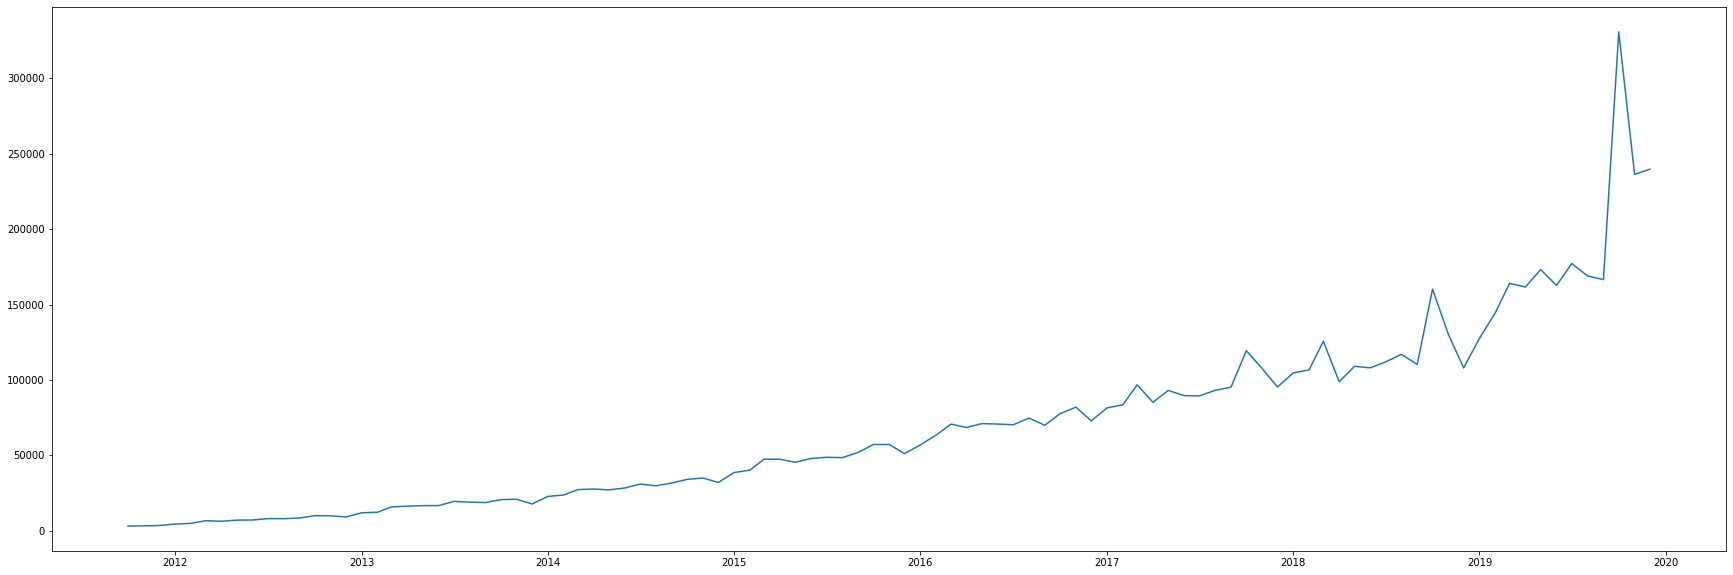

In [12]:
plt.plot(general_languagues_dict['Python'])

## ARIMA model

I used Python for testing purposes. I will adapt the code for the top 20 languages

Index(['Count'], dtype='object')


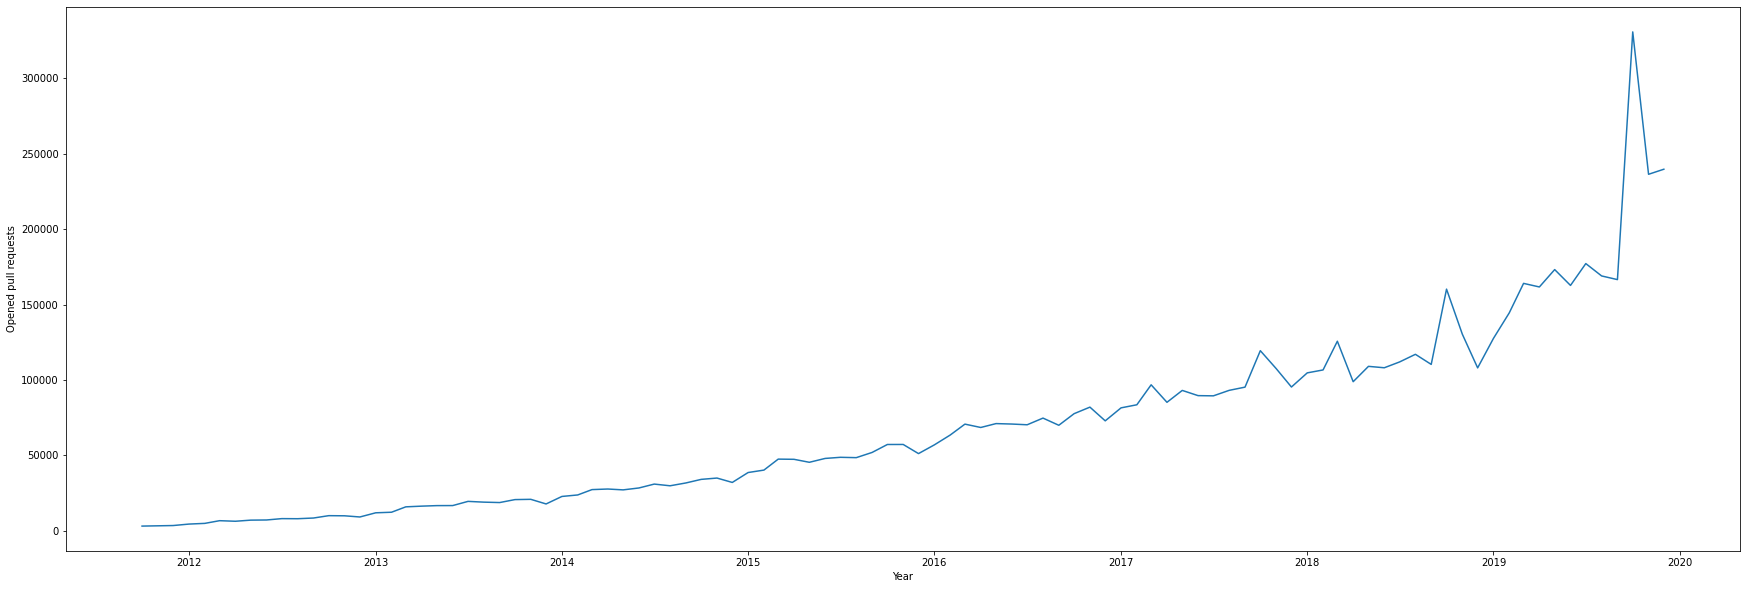

In [13]:
general_languagues_dict['Python'].head()
print(general_languagues_dict['Python'].columns)

plt.plot(general_languagues_dict['Python'])
plt.xlabel('Year')
plt.ylabel('Opened pull requests')
plt.show()

general_languagues_dict['Python'].index

python_df = general_languagues_dict['Python']

Add missing dates to the df. Remember that we want monthly records

In [14]:
python_df.index = python_df.index.to_period('m').to_timestamp()
python_df = python_df.asfreq('MS')

# print(python_df.index)
# print(python_df.head)

Fill those missing dates values with the value at (n-1)

In [15]:
python_df = python_df.ffill(axis ='rows')

# python_df

In [16]:
python_df.dtypes

Count    float64
dtype: object

The rolling mean and std shouldn't increase over time, plotting them gives you a visual aid

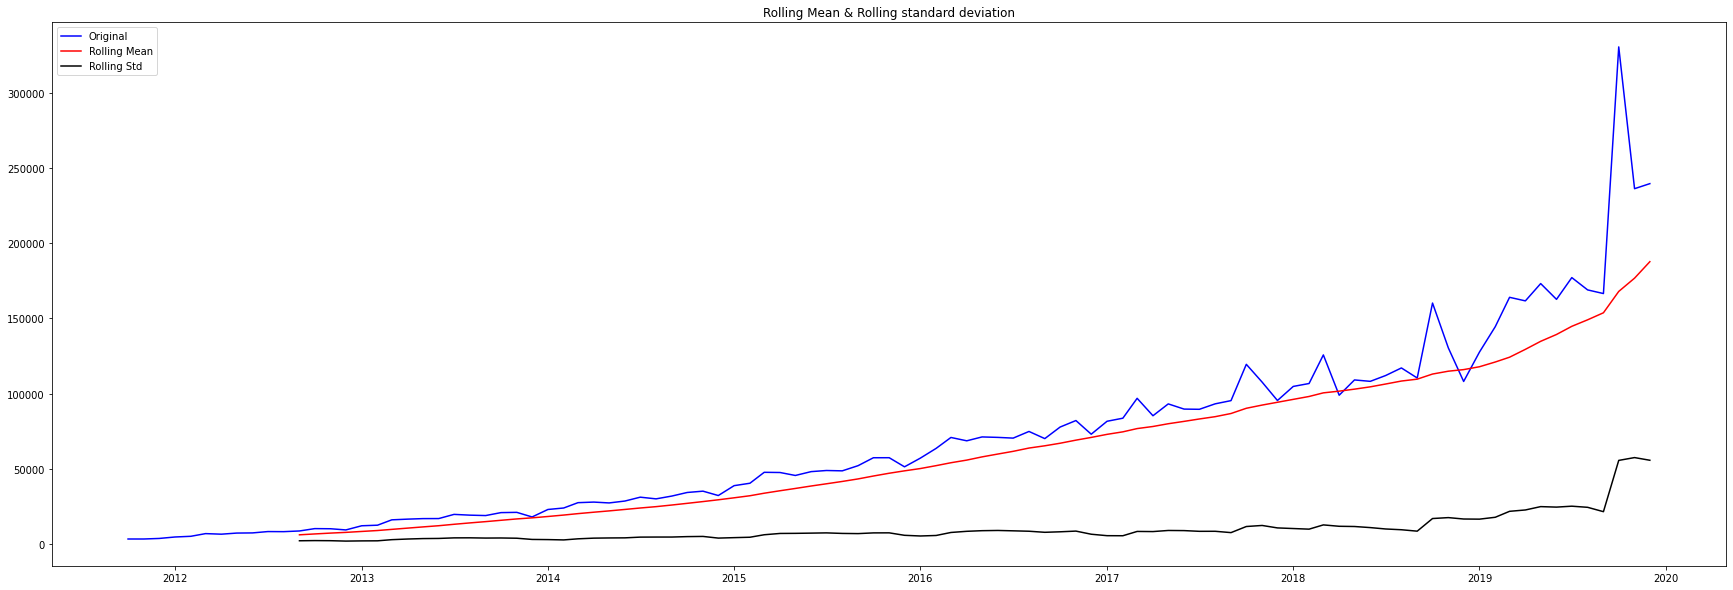

In [17]:
rolling_mean = python_df.rolling(window=12).mean()
rolling_std = python_df.rolling(window=12).std()

# print(rolling_mean)
# print(rolling_std)

plt.plot(python_df, color='blue', label='Original')
plt.plot(rolling_mean, color='red',label='Rolling Mean')
plt.plot(rolling_std, color='black',label='Rolling Std')
plt.legend(loc = 'best')
plt.title('Rolling Mean & Rolling standard deviation')
plt.show()

Conduct Dickey-Fuller test to check p-value

In [18]:
print("Dickey-Fuller Test Results: ")
dftest = adfuller(python_df['Count'], autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
  dfoutput['Critical Value (%s)'%key] = value

print(dfoutput)

Dickey-Fuller Test Results: 
Test Statistic                 -0.288844
p-value                         0.927070
#Lags Used                     12.000000
Number of Observations Used    86.000000
Critical Value (1%)            -3.508783
Critical Value (5%)            -2.895784
Critical Value (10%)           -2.585038
dtype: float64


If the data is not stationary, we can take the log of it to try to make it stationary

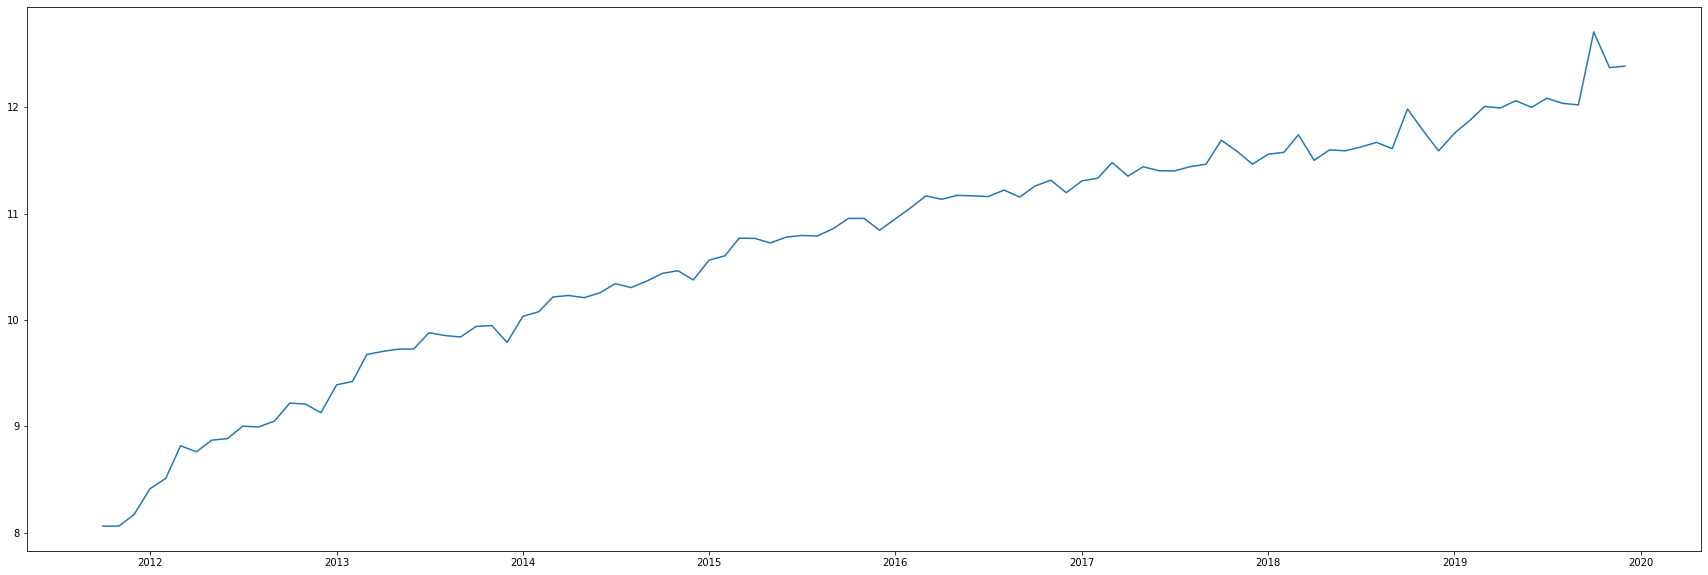

In [19]:
#Estimating trend

indexedDataset_logScale = np.log(python_df)
plt.plot(indexedDataset_logScale)

# df_log = np.log(stat_test)
# plt.plot(df_log)

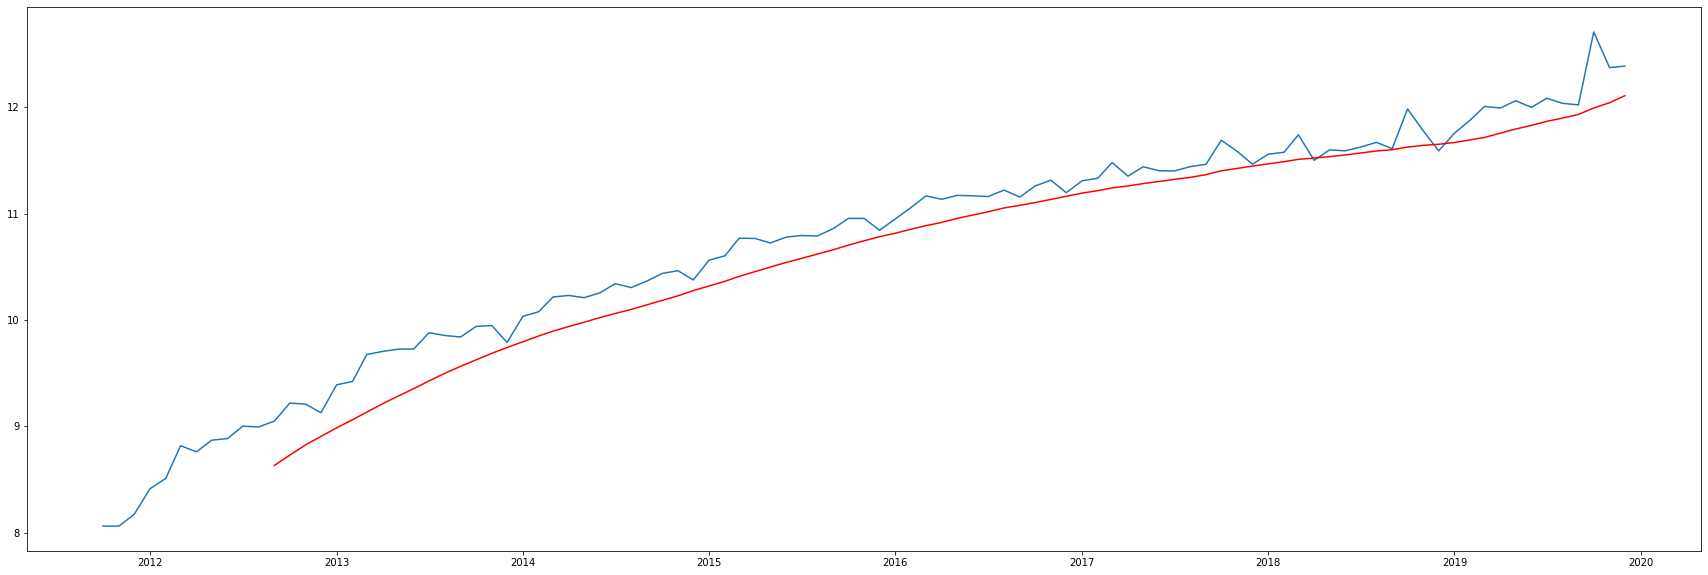

In [20]:
movingAverage = indexedDataset_logScale.rolling(window=12).mean()
movingSTD = indexedDataset_logScale.rolling(window=12).std()
plt.plot(indexedDataset_logScale)
plt.plot(movingAverage, color='red')

In [22]:
def test_stationarity(timeseries):
    
    # rolling statistics
    movingAverage = timeseries.rolling(window=12).mean()
    movingSTD = timeseries.rolling(window=12).std()

    # rolling statistics plot
    original = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(movingAverage, color='red', label='Rolling Mean')
    std = plt.plot(movingSTD, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Dickey–Fuller test:
    print('Dickey-Fuller test results: ')
    dftest = adfuller(timeseries['Count'], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
      dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

There are multiple ways to convert the data into stationary data. One of them is substracting the moving average from the log

In [21]:
datasetLogScaleMinusMovingAverage = indexedDataset_logScale - movingAverage
datasetLogScaleMinusMovingAverage.dropna(inplace=True)
# datasetLogScaleMinusMovingAverage.head(5)

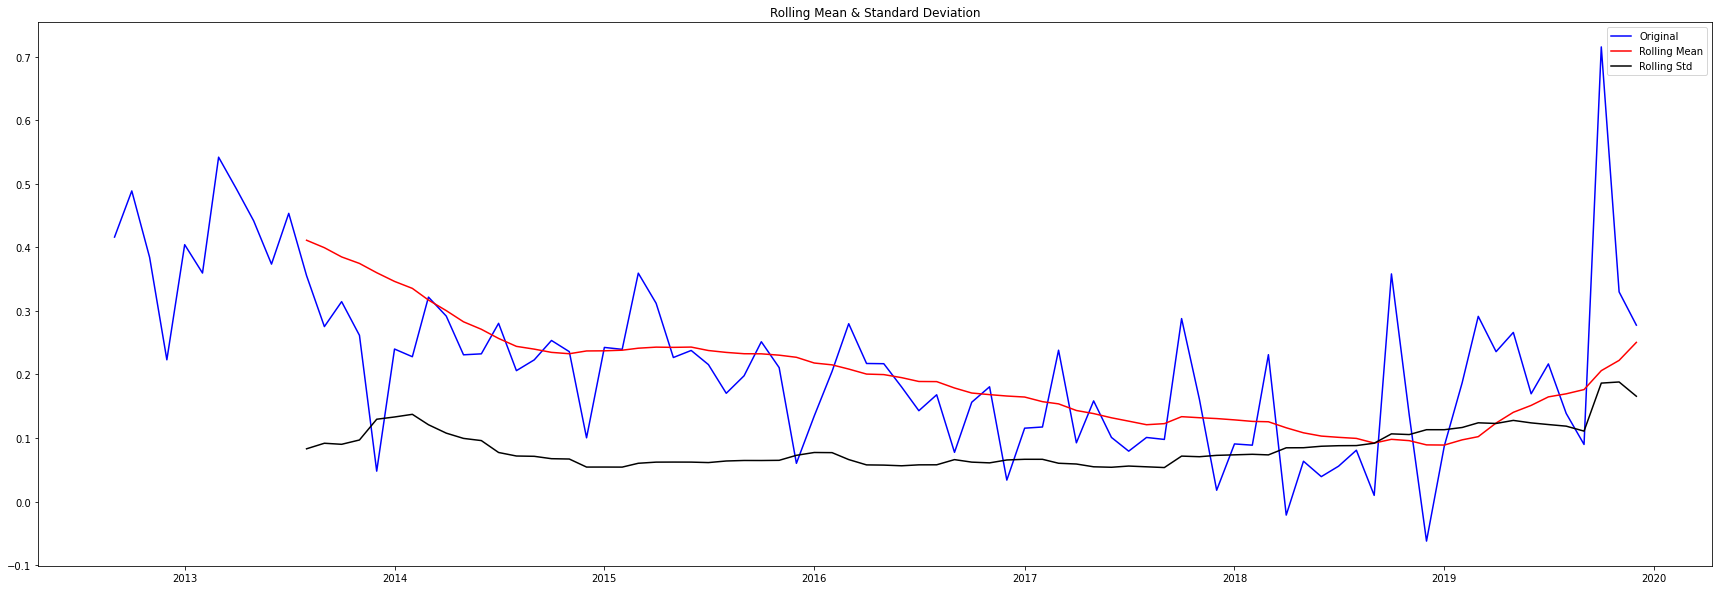

Dickey-Fuller test results: 
Test Statistic                 -1.681656
p-value                         0.440588
#Lags Used                     12.000000
Number of Observations Used    75.000000
Critical Value (1%)            -3.520713
Critical Value (5%)            -2.900925
Critical Value (10%)           -2.587781
dtype: float64


In [23]:
test_stationarity(datasetLogScaleMinusMovingAverage)

Another way to convert data into stationary data is to substract the exponential decay from the log

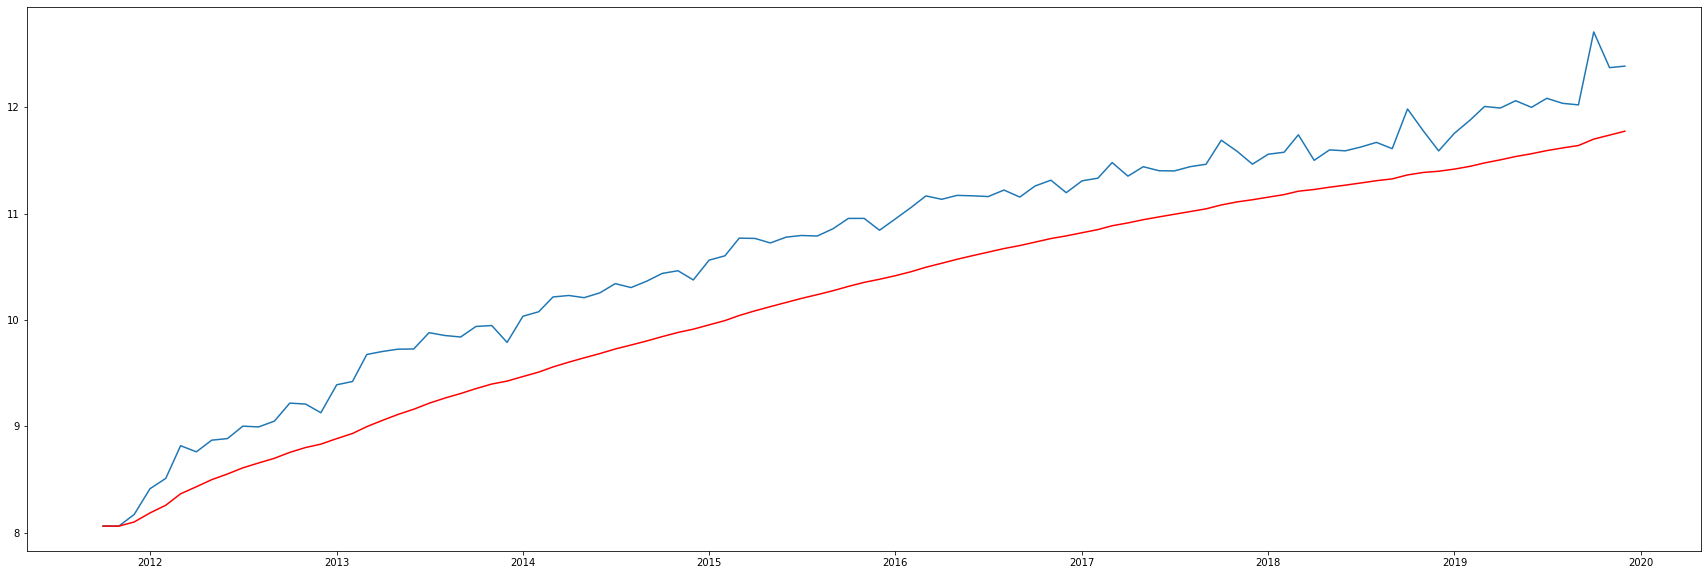

In [24]:
exponentialDecayWeightedAverage = indexedDataset_logScale.ewm(halflife=12,min_periods=0,adjust=True).mean()
plt.plot(indexedDataset_logScale)
plt.plot(exponentialDecayWeightedAverage,color='red')

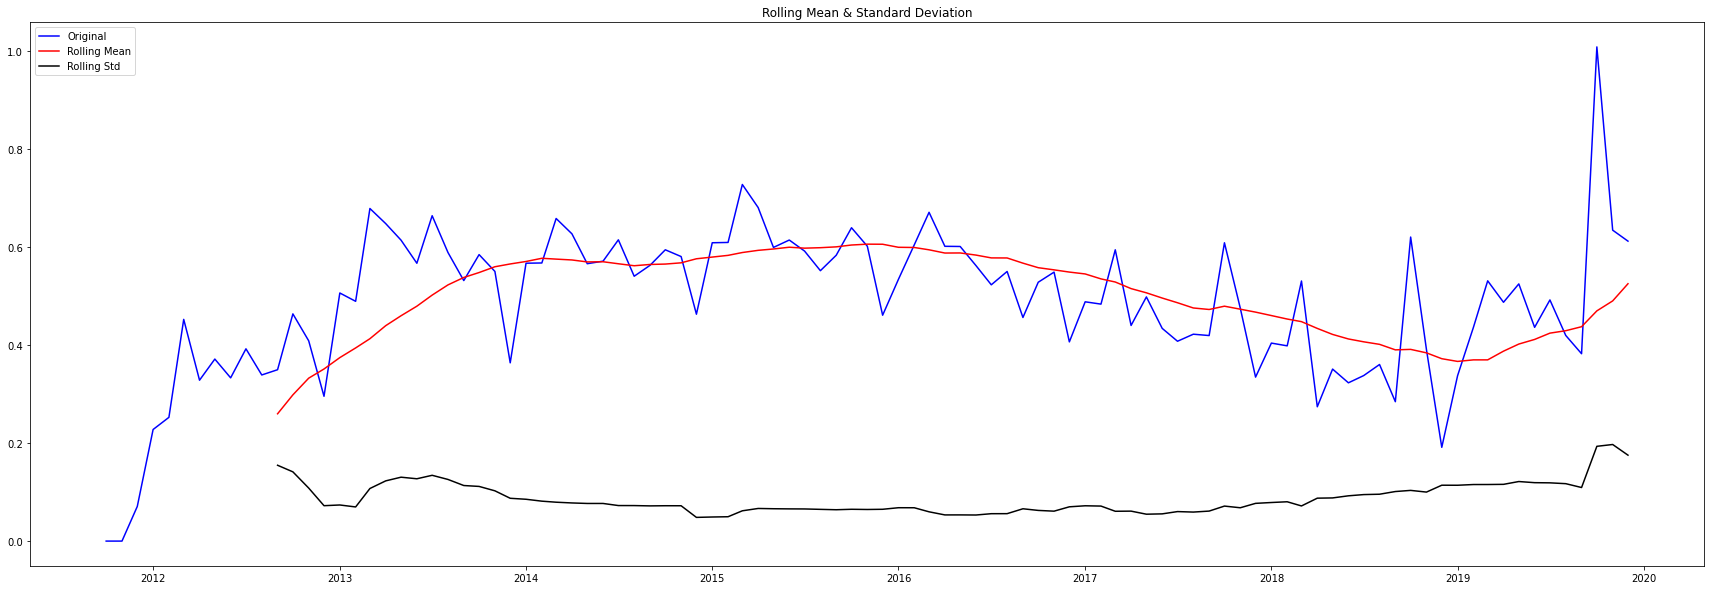

Dickey-Fuller test results: 
Test Statistic                 -1.744644
p-value                         0.408270
#Lags Used                     12.000000
Number of Observations Used    86.000000
Critical Value (1%)            -3.508783
Critical Value (5%)            -2.895784
Critical Value (10%)           -2.585038
dtype: float64


In [25]:
datasetLogScaleMinusMovingExponentialDecayAverage = indexedDataset_logScale - exponentialDecayWeightedAverage
test_stationarity(datasetLogScaleMinusMovingExponentialDecayAverage)


A third method is to take the shift and substract it from the log. This will try to reduce the noise.

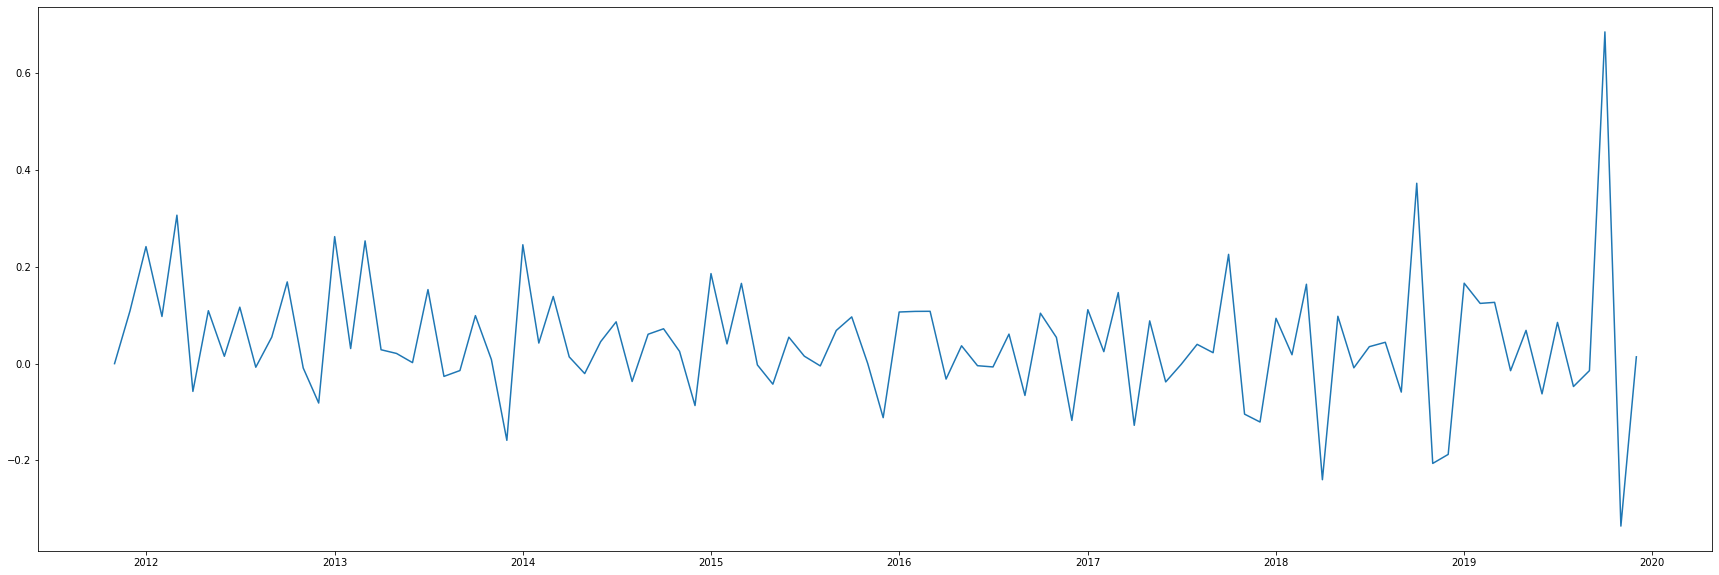

In [26]:
datasetLogDiffShifting = indexedDataset_logScale - indexedDataset_logScale.shift()
plt.plot(datasetLogDiffShifting)

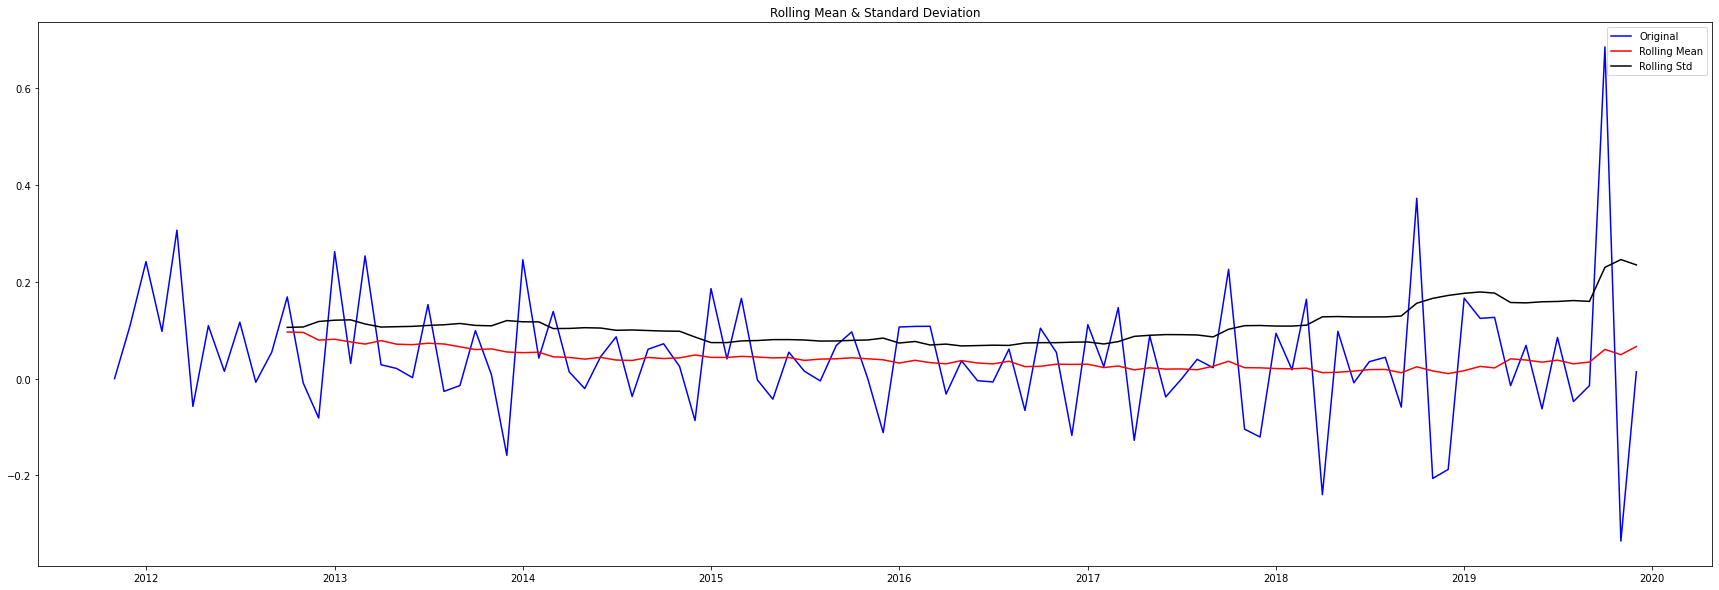

Dickey-Fuller test results: 
Test Statistic                 -2.214646
p-value                         0.200973
#Lags Used                     12.000000
Number of Observations Used    85.000000
Critical Value (1%)            -3.509736
Critical Value (5%)            -2.896195
Critical Value (10%)           -2.585258
dtype: float64


In [27]:
datasetLogDiffShifting.dropna(inplace=True)
test_stationarity(datasetLogDiffShifting)

Decompose data to check trend, seasonality and noise

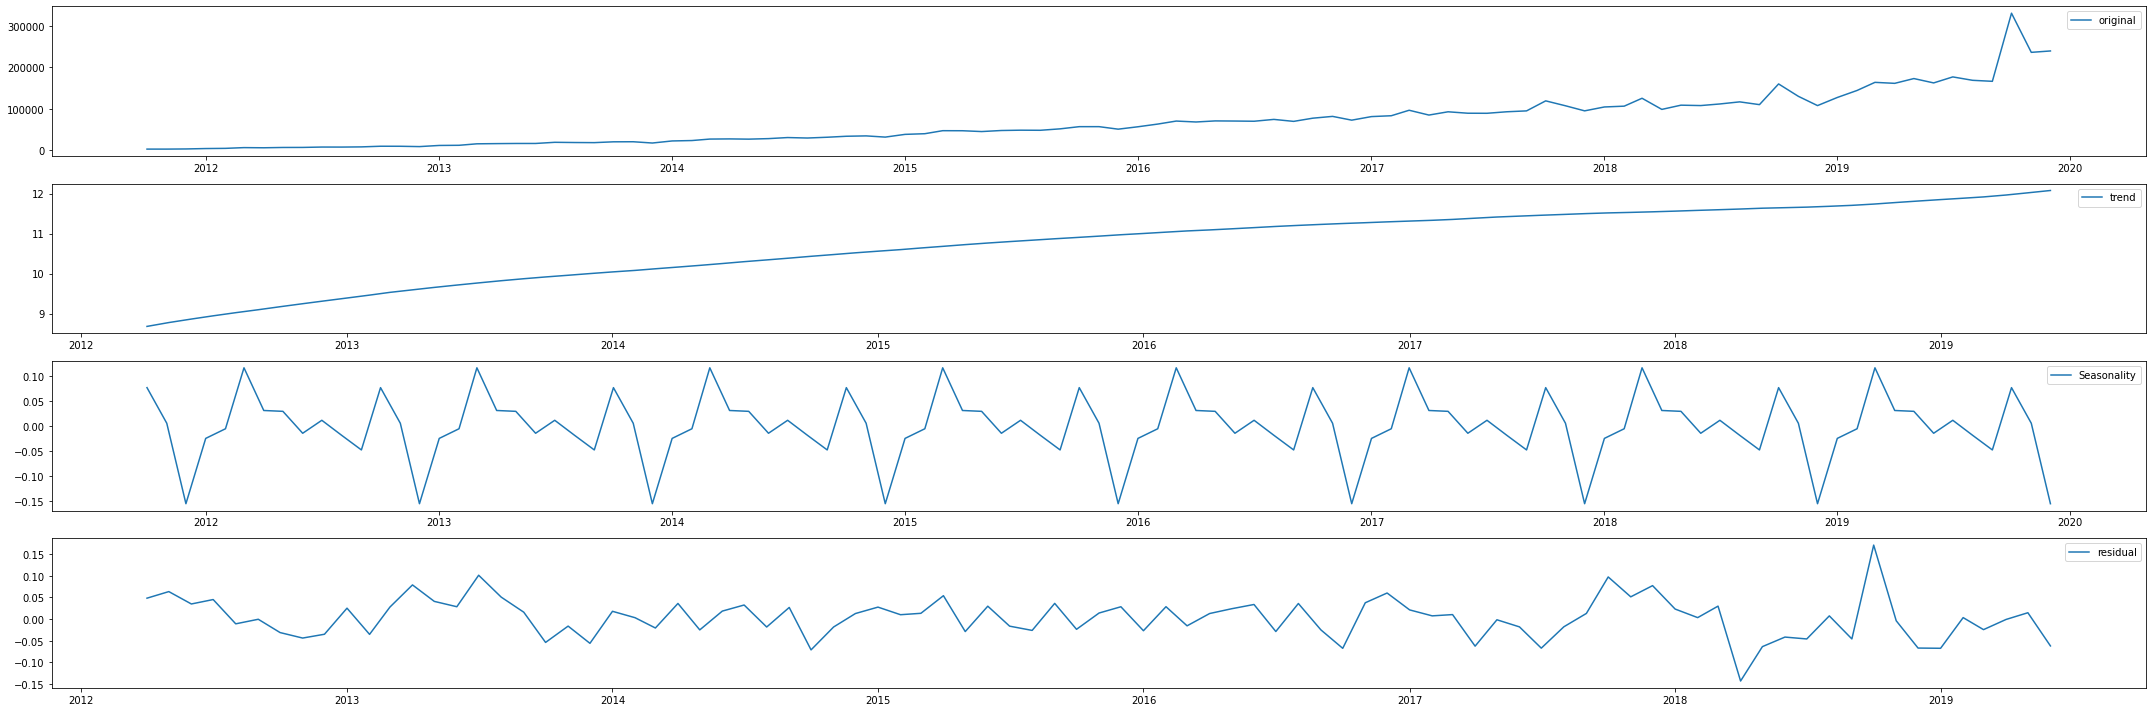

In [28]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(indexedDataset_logScale)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(python_df,label='original')
plt.legend(loc = 'best')
plt.subplot(412)
plt.plot(trend, label = 'trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label = 'residual')
plt.legend(loc='best')
plt.tight_layout()

In [29]:
# decomposedLogData = residual
# decomposedLogData.dropna(inplace=True)
# test_stationarity(decomposedLogData)

In order to get the parameters for ARIMA we need to check the acf and pacf

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


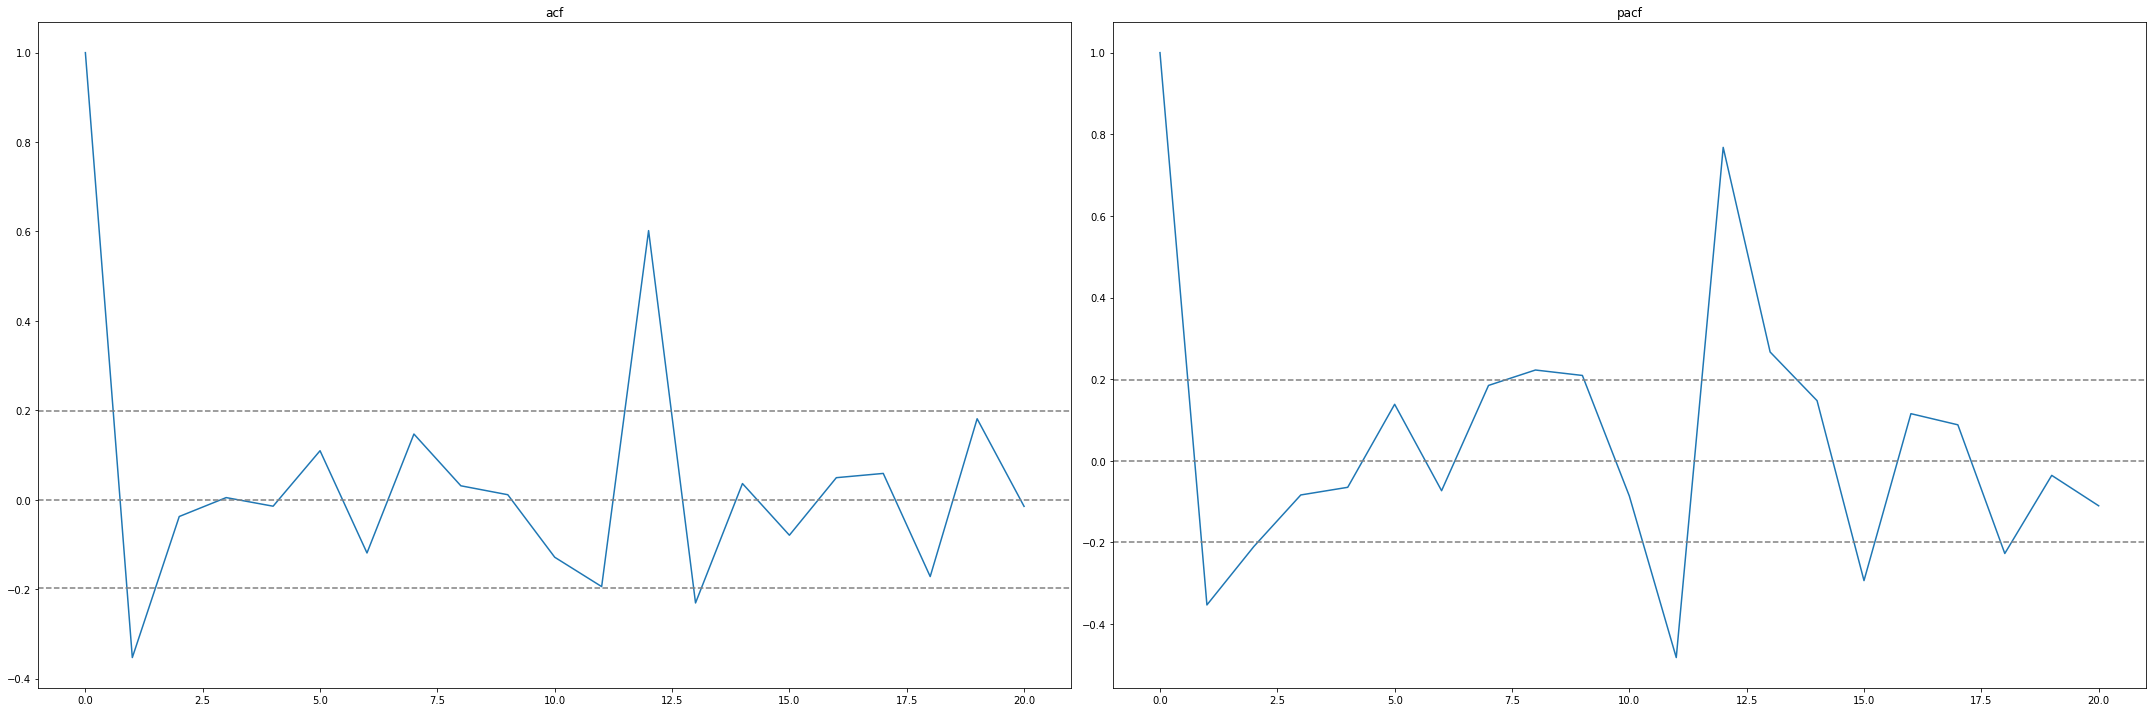

In [30]:
from statsmodels.tsa.stattools import acf, pacf

lag_acf = acf(datasetLogDiffShifting,nlags=20)
lag_pacf = pacf(datasetLogDiffShifting,nlags=20,method='ols')

#plot acf:
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(datasetLogDiffShifting)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(datasetLogDiffShifting)),linestyle='--',color='gray')
plt.title('acf')

#plot pacf:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(datasetLogDiffShifting)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(datasetLogDiffShifting)),linestyle='--',color='gray')
plt.title('pacf')
plt.tight_layout()

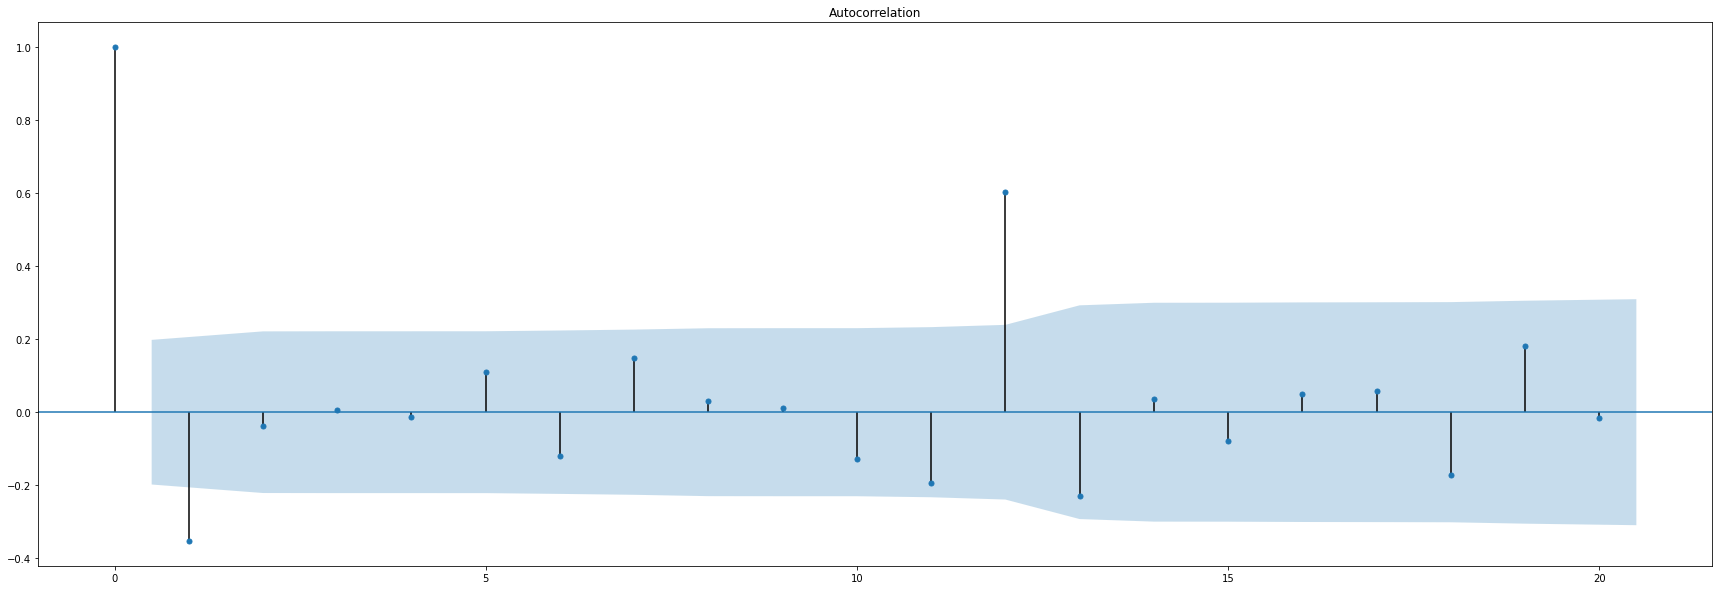

In [31]:
from statsmodels.graphics import tsaplots
statsmodels.graphics.tsaplots.plot_acf(datasetLogDiffShifting);

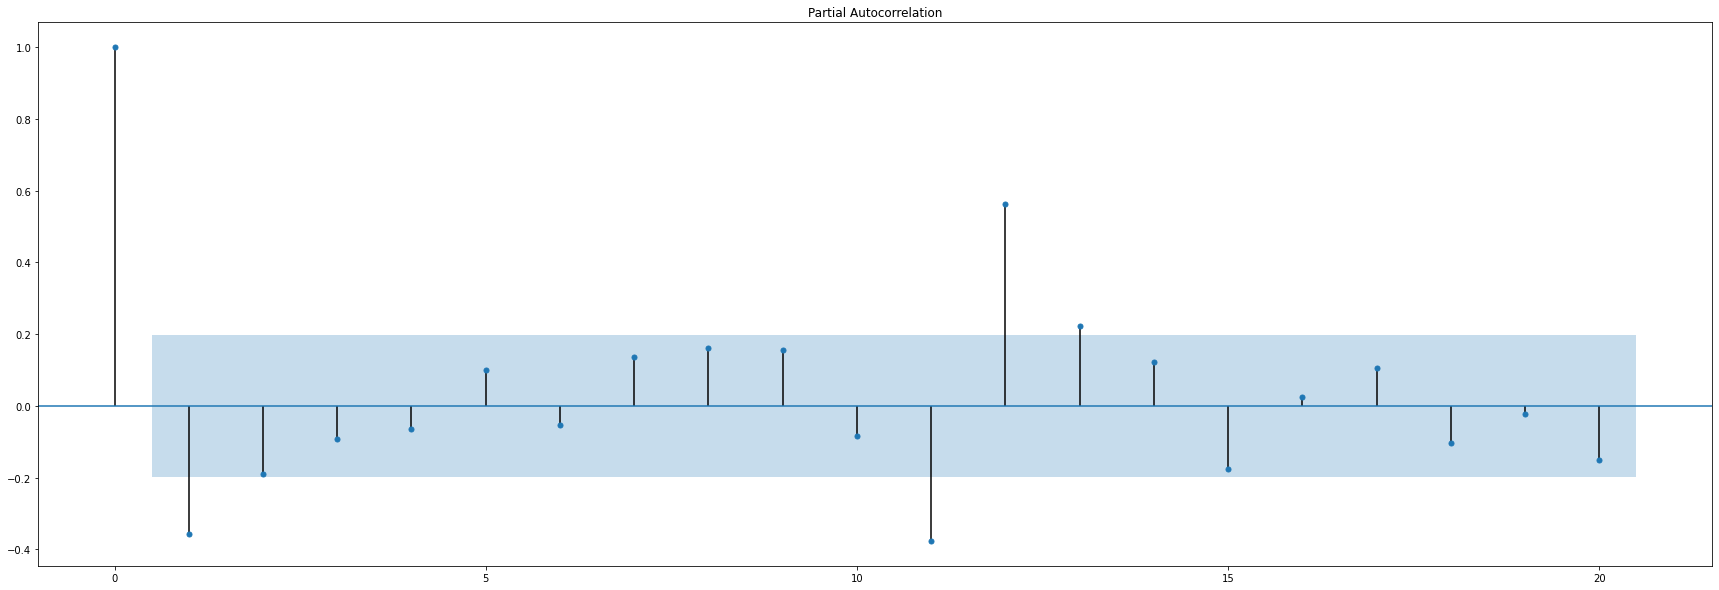

In [32]:
statsmodels.graphics.tsaplots.plot_pacf(datasetLogDiffShifting);

Fit an ARIMA model based on the above results. We have to select the lag number where ACF and PACF drop to 0

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


Text(0.5, 1.0, 'RSS 1.1843')

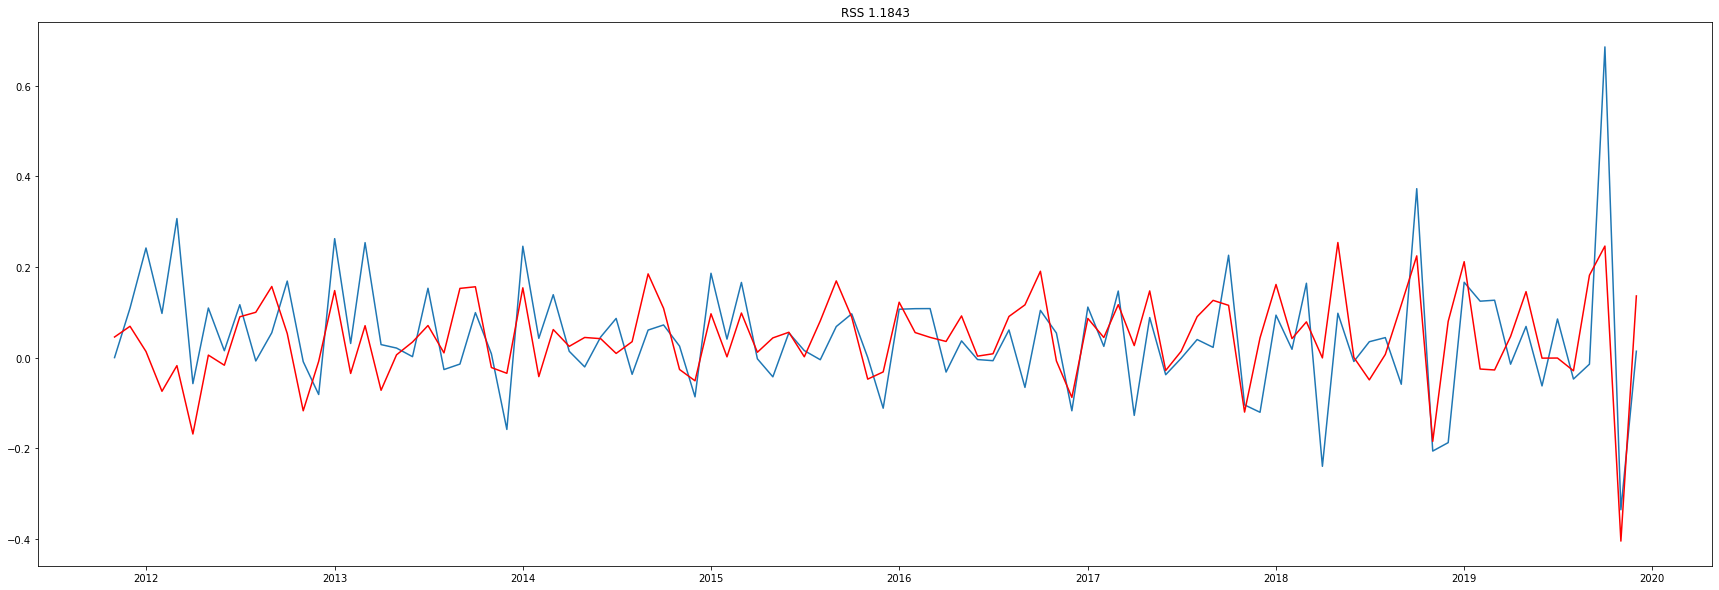

In [33]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(indexedDataset_logScale, order=(3,1,5))
results_ARIMA = model.fit(disp=-1)
plt.plot(datasetLogDiffShifting)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS %.4f'% sum((results_ARIMA.fittedvalues-datasetLogDiffShifting['Count'])**2))


In [34]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
# print(predictions_ARIMA_diff.head())

In [35]:
#convert to cumulative sum
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
# print(predictions_ARIMA_diff_cumsum.head())

In [36]:
predictions_ARIMA_log = pd.Series(indexedDataset_logScale['Count'].iloc[0],index=indexedDataset_logScale.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()


Year
2011-10-01    8.062433
2011-11-01    8.107896
2011-12-01    8.177065
2012-01-01    8.190547
2012-02-01    8.116202
Freq: MS, dtype: float64

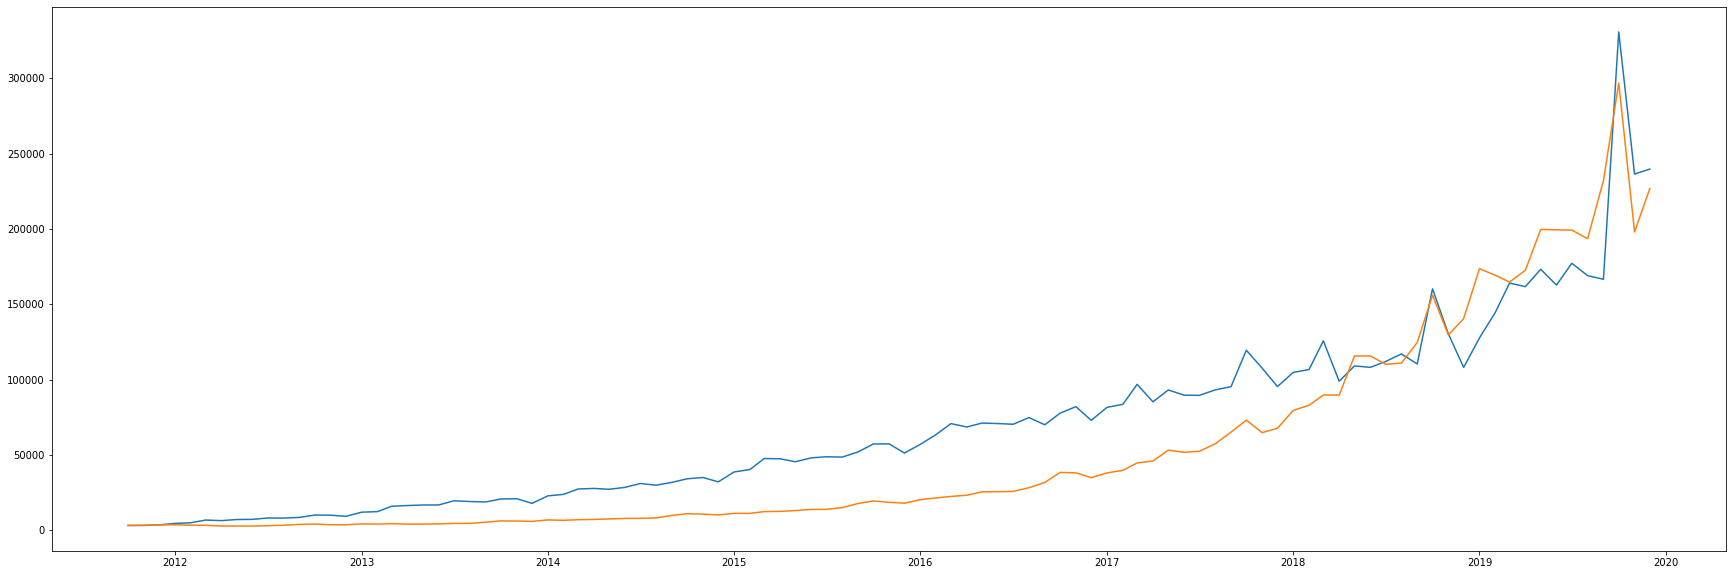

In [37]:
#Undo the log

predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(python_df)
# plt.figure()
plt.plot(predictions_ARIMA)

Get predictions for the next year

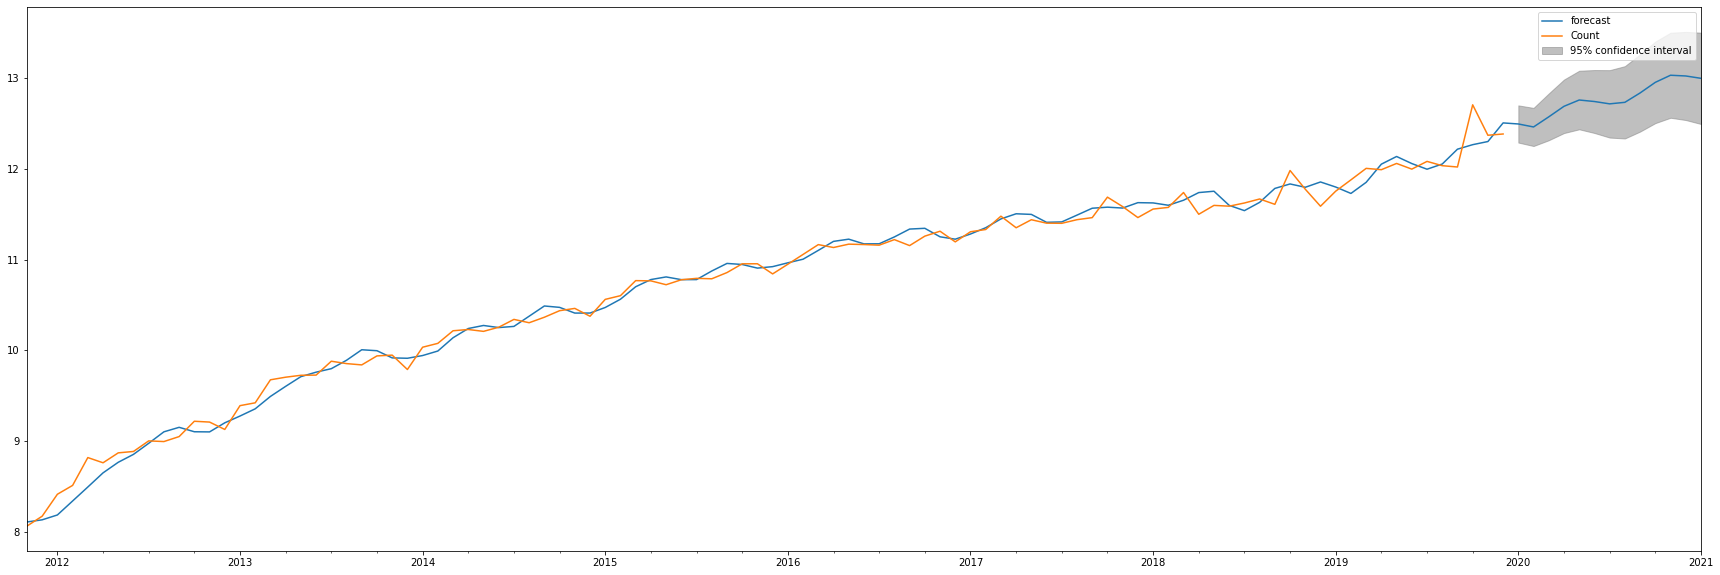

In [38]:
rows_to_predict = int(indexedDataset_logScale.shape[0])+12 # number of rows + 12 months
results_ARIMA.plot_predict(1,rows_to_predict);

The previous plot does show the predictions for the upcoming year. However, the scale used at the y-axis is incorrect. We can take the prediction results and plot them in a more appropriate graph.

In [39]:
forecast_values = results_ARIMA.forecast(steps=12)
# forecast_values

prediction_values = forecast_values[0]
prediction_values = np.exp(prediction_values)

confidence_intervals_y1 = forecast_values[2]
confidence_intervals_y1 = [i[0] for i in confidence_intervals_y1]
confidence_intervals_y1 = np.exp(confidence_intervals_y1)

confidence_intervals_y2 = forecast_values[2]
confidence_intervals_y2 = [i[1] for i in confidence_intervals_y2]
confidence_intervals_y2 = np.exp(confidence_intervals_y2)

In [40]:
df_copy = python_df.copy()
# df_copy

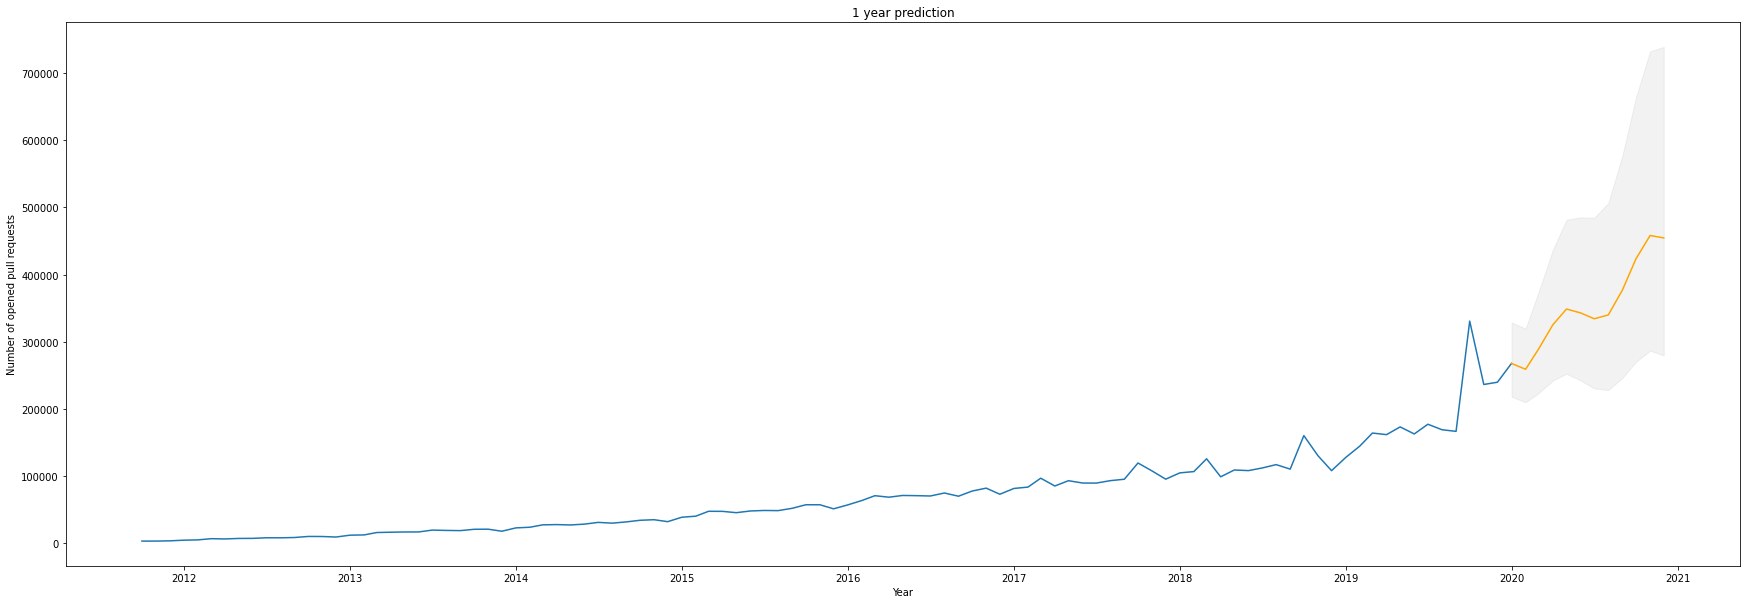

In [41]:
d = {'Year': ['2020-01-01',
              '2020-02-01',
              '2020-03-01',
              '2020-04-01',
              '2020-05-01',
              '2020-06-01',
              '2020-07-01',
              '2020-08-01',
              '2020-09-01',
              '2020-10-01',
              '2020-11-01',
              '2020-12-01',], 'Count': list(prediction_values)}
next_year_df = pd.DataFrame(data=d)

next_year_predictions = next_year_df.set_index(['Year'])
next_year_predictions.sort_index(inplace=True)
next_year_predictions = next_year_predictions.asfreq('MS')
df_copy = df_copy.append(next_year_predictions)

plt.title("1 year prediction")
plt.xlabel("Year")
plt.ylabel("Number of opened pull requests")
plt.plot(df_copy[:-11])
plt.plot(df_copy[-12:],color='orange')

fill = df_copy.index[-12:]
plt.fill_between(fill, confidence_intervals_y1, confidence_intervals_y2, color='gray', alpha=.1)


# RNN 

In [ ]:
professional_languages_dict.keys()

# Univariate multi-step model

In [ ]:
tf.random.set_seed(13)

In [ ]:
def create_time_steps(length):
  return list(range(-length, 0))

In [ ]:
def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

In [ ]:
'''Plotting a sample data-point'''

def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(50, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history[:]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()

def multi_step_plot_tail(history, true_future, prediction):
  plt.figure(figsize=(18, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history[:]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper x_val_multileft')
  plt.xlim([-10, 30])
  plt.show()

In [ ]:
def baseline(history):
  return np.mean(history)

In [ ]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

In [ ]:
#HYPERPARAMETERS
EVALUATION_INTERVAL = 60
EPOCHS = 100
past_history = 12
future_target = 12
STEP = 1
BATCH_SIZE = 60
BUFFER_SIZE = 10000
ValidationSteps = 10
LEARNING_RATE_VALUE = 0.05

In [ ]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    # if single_step:
    #   labels.append(target[i+target_size])
    # else:
    #   labels.append(target[i:i+target_size])

    labels_index = range(i,i+target_size,step)
    labels.append(dataset[labels_index])
    
  return np.array(data), np.array(labels)

In [ ]:
count = 1
unidata_dicts = {}
train_history_dicts = {}

for key in general_languagues_dict.keys():
  # print(general_languagues_dict[key].dtypes)
  if(count > 1):
    break
  
  count +=1 
  
  # uni_data = general_languagues_dict[key]['Count']
  uni_data = df_log_shift['Count']
  

  # uni_data.index =  general_languagues_dict[key]['Year']
  uni_data.index =  df_log_shift.index


  print("Language: Python",key)
  print(uni_data)

  uni_data.plot(subplots=True)

  uni_data = uni_data.values

  TRAIN_SPLIT = int(len(uni_data)*0.7)

  print("Train split",TRAIN_SPLIT)

  # uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
  # uni_train_std = uni_data[:TRAIN_SPLIT].std()

#   dataset = (uni_data-uni_train_mean)/uni_train_std

#   print("len", len(dataset))

  dataset = uni_data
  x_train_multi, y_train_multi = multivariate_data(dataset, dataset, 0,
                                                  TRAIN_SPLIT, past_history,
                                                  future_target, STEP)
  x_val_multi, y_val_multi = multivariate_data(dataset, dataset, TRAIN_SPLIT,
                                              None, past_history,
                                              future_target, STEP)

  print(x_train_multi.shape)
  print(x_val_multi.shape)
  print(x_train_multi,y_train_multi)
  x_train_multi = np.expand_dims(x_train_multi, axis=2) #The train parameters have to be a 3d vector, when we are using a univariate we have to reshape
  x_val_multi = np.expand_dims(x_val_multi, axis=2)

# ################################################################################

#   '''Let's check out a sample data-point'''

  print ('Single window of past history : {}'.format(x_train_multi[0].shape))
  print ('\n Target to predict : {}'.format(y_train_multi[0].shape))

# ################################################################################

  train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
  train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

  val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
  val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

# ################################################################################

  for x, y in train_data_multi.take(1):
    multi_step_plot(x[0], y[0], np.array([0]))
    break;

# ################################################################################

  print(x_train_multi.shape[-2:])

# ################################################################################

  multi_step_model = tf.keras.models.Sequential()
  multi_step_model.add(tf.keras.layers.LSTM(32,
                                            return_sequences=True,
                                            input_shape=x_train_multi.shape[-2:]))
  multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
  multi_step_model.add(tf.keras.layers.Dense(future_target))


  sgd = tf.keras.optimizers.SGD(learning_rate=LEARNING_RATE_VALUE, decay=1e-6, momentum=0.9, nesterov=True)
      # single_step_model.compile(optimizer=sgd, loss='mae')
  # multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')
  multi_step_model.compile(optimizer = sgd, loss='mae')

# ################################################################################

  '''Let's see how the model predicts before it trains'''

  for x, y in val_data_multi.take(1):
    print(multi_step_model.predict(x).shape)

# ################################################################################

  multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_multi,
                                            validation_steps=ValidationSteps)
  
  train_history_dicts[key] = multi_step_history
# ################################################################################

  plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

# ################################################################################


#   '''Let's now have a look at how well your network has learnt to predict the future'''

  for x, y in val_data_multi.take(3):
    multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])

# ################################################################################

